-add version

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import calendar
from datetime import date
import datetime
from calendar import monthrange
import calendar
import numpy as np
import re
import string

import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import getpass
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/litalertlumprasert/opt/anaconda3/lib/python3.9/site-packages/snowflake/connector/options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
con = snowflake.connector.connect(
    user='LITA',
    password=getpass.getpass(prompt='Password: ', stream=None),
    account='tga60420',
    warehouse='COMPUTE_WH',
    database='ANALYST',
    schema='TEMP'
)

Password: ········


In [3]:
#get planned revenue
query = """SELECT MON_YR, REVENUE, VERSION FROM FIVETRAN_DATABASE.GOOGLE_SHEETS.REVENUE_PLANNING"""
cur = con.cursor()
cur.execute(query)
plan = cur.fetchall()
cur.close()

plan = pd.DataFrame(plan, columns=['mon_yr', 'planned_rev', 'version'])
plan['mon_yr'] = plan['mon_yr'].astype('str')
plan.head()

,mon_yr,planned_rev,version
0,2023-01-01,7800000,1
1,2023-02-01,7600000,1
2,2023-03-01,8600000,1
3,2023-04-01,8500000,1
4,2023-05-01,9000000,1


In [4]:
#get actual
query = """SELECT DATE(TRANDATE) DATE
       ,COALESCE(SUM(-1 * AMOUNT), 0) revenue
FROM FIVETRAN_DATABASE.NETSUITE.TRANSACTION_LINES trans
INNER JOIN (
    SELECT ITEM_ID
    , NAME
    , CLASS_ID
    , PURCHASEDESCRIPTION
    FROM FIVETRAN_DATABASE.NETSUITE.ITEMS
    GROUP BY 1, 2, 3, 4
    ) items
ON trans.ITEM_ID = items.ITEM_ID
JOIN (
    SELECT i.LIST_ITEM_NAME CHANNEL
    , t.TRANSACTION_ID
    , t.TRANSACTION_TYPE
    , t.TRANDATE
    , t.STATUS
    FROM FIVETRAN_DATABASE.NETSUITE.TRANSACTIONS t
    LEFT JOIN FIVETRAN_DATABASE.NETSUITE.ENTITY e
    ON t.ENTITY_ID = e.ENTITY_ID
    LEFT JOIN FIVETRAN_DATABASE.NETSUITE.INDUSTRY i
    ON e.INDUSTRY_ID = i.LIST_ID
) ind
ON trans.TRANSACTION_ID = ind.TRANSACTION_ID
LEFT JOIN FIVETRAN_DATABASE.NETSUITE.CLASSES class
ON items.CLASS_ID = class.CLASS_ID

WHERE trans.TRANSACTION_LINE_ID > 0
AND COALESCE(class.FULL_NAME, '') <> 'Z: FEES / OTHER'
AND COALESCE(AMOUNT, 0) <> 0
AND TRANSACTION_TYPE IN ('Cash Sale', 'Invoice', 'Credit Memo')
AND items.NAME NOT IN ('Sales Tax', 'Shipping Charge')
AND DATE(TRANDATE) >= DATEFROMPARTS(YEAR(GETDATE()) - 3, 1, 1)
GROUP BY 1
ORDER BY 1"""
cur = con.cursor()
cur.execute(query)
actual = cur.fetchall()
cur.close()

actual = pd.DataFrame(actual, columns=['date', 'actual_rev'])
actual['date'] = pd.to_datetime(actual['date'])
actual['dow'] = actual['date'].dt.weekday
actual.head()

,date,actual_rev,dow
0,2020-01-02,61433.660,3
1,2020-01-03,77208.500,4
2,2020-01-06,66840.860,0
3,2020-01-07,101954.190,1
4,2020-01-08,114528.950,2


In [5]:
dow_count = actual.groupby('dow').count().reset_index()[['dow','date']]
dow_avg = actual.groupby('dow').mean().reset_index()[['dow','actual_rev']]
actual_norm = pd.concat([dow_avg, dow_count], axis=1)
actual_norm = actual_norm.iloc[:, [0,1,3]].fillna(0)
actual_norm.columns = ['dow', 'avg_rev', 'count']
weekly_sum = actual_norm['avg_rev'].sum()
actual_norm['per'] = actual_norm['avg_rev']/weekly_sum
actual_norm


,dow,avg_rev,count,per
0,0,191889.603,149,0.175
1,1,221146.794,158,0.201
2,2,260294.356,158,0.237
3,3,189658.116,154,0.173
4,4,199205.638,151,0.181
5,5,28571.552,6,0.026
6,6,8086.137,9,0.007


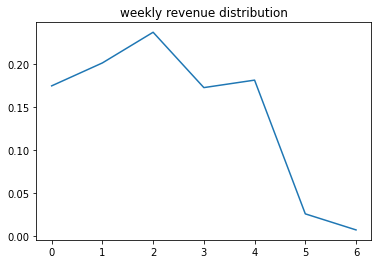

In [6]:
plt.plot(actual_norm['per'].values)
plt.title('weekly revenue distribution')
plt.show()

In [25]:
output = pd.DataFrame()
yr_forecast = 2023
mths = [1,2,3,4,5,6,7,8,9,10,11,12]
for mth_forecast in mths:
    #count how many days are there a specific dow in the month
    cal = calendar.Calendar()

    count_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    for week in cal.monthdayscalendar(yr_forecast, mth_forecast):
        for i, day in enumerate(week):
            if day != 0:
                count_dict[i] = count_dict[i] + 1
                
    #get percentage distribution for a specific dow
    count_dict_per = count_dict.copy()
    for key,value in count_dict_per.items():
        count_dict_per[key] = value * actual_norm.loc[key, 'per']

    sum_ = 0
    for key,value in count_dict_per.items():
        sum_ = sum_ + value

    for key,value in count_dict_per.items():
        count_dict_per[key] = value * 100 / sum_

    count_dict_fin = count_dict_per.copy()
    for key,value in count_dict_fin.items():
        count_dict_fin[key] = count_dict_fin[key] / count_dict[key]
    
    mon_yr = str(yr_forecast)+'-'+str("{:02d}".format(mth_forecast))+'-'+'01'
    for v in plan.loc[plan['mon_yr']==mon_yr, 'version'].values:
        rev_ = plan.loc[(plan['mon_yr']==mon_yr)&(plan['version']==v), 'planned_rev'].values[0]

        #get lead volume for specific day
        df = pd.DataFrame()
        df['date'] = list(range(1, monthrange(yr_forecast, mth_forecast)[1]+1))

        #get dow
        def get_dow_col(yr, mth, start_date, end_date):
            weekday = []
            for date in range(start_date, end_date+1):
                weekday.append(datetime.date(yr, mth, date).weekday())
            return weekday
        df['dow'] = get_dow_col(yr_forecast, mth_forecast, 1, df['date'].max())

        def getweight(row, count_dict_fin, rev_):
            dow = row['dow']
            return rev_ * count_dict_fin[dow] * 0.01
        df['planned_vol_day'] = df.apply(getweight, args=(count_dict_fin, rev_), axis=1)

        df['mon_yr'] = mon_yr
        df['pacing'] = df['planned_vol_day'].cumsum()
        df['date'] = [str(yr_forecast)+'-'+str("{:02d}".format(mth_forecast))+'-'+str("{:02d}".format(d[1])) for d in df['date'].iteritems()]
        df['version'] = v

        output = pd.concat([output, df], axis=0)

In [26]:
output

,date,dow,planned_vol_day,mon_yr,pacing,version
0,2023-01-01,6,13094.873,2023-01-01,13094.873,1
1,2023-01-02,0,310750.374,2023-01-01,323845.247,1
2,2023-01-03,1,358130.131,2023-01-01,681975.378,1
3,2023-01-04,2,421526.582,2023-01-01,1103501.959,1
4,2023-01-05,3,307136.652,2023-01-01,1410638.611,1
...,...,...,...,...,...,...
26,2023-12-27,2,730647.337,2023-12-01,11805559.549,2
27,2023-12-28,3,532371.117,2023-12-01,12337930.666,2
28,2023-12-29,4,559171.051,2023-12-01,12897101.717,2
29,2023-12-30,5,80200.464,2023-12-01,12977302.181,2


In [27]:
output = output.reset_index()
output = output[['mon_yr', 'date', 'planned_vol_day', 'pacing', 'version']]
output.columns = ['MON_YR', 'DATE', 'PLANNED_VOL_DAY', 'PACING', 'VERSION']
output.head()

,MON_YR,DATE,PLANNED_VOL_DAY,PACING,VERSION
0,2023-01-01,2023-01-01,13094.873,13094.873,1
1,2023-01-01,2023-01-02,310750.374,323845.247,1
2,2023-01-01,2023-01-03,358130.131,681975.378,1
3,2023-01-01,2023-01-04,421526.582,1103501.959,1
4,2023-01-01,2023-01-05,307136.652,1410638.611,1


In [28]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MON_YR           730 non-null    object 
 1   DATE             730 non-null    object 
 2   PLANNED_VOL_DAY  730 non-null    float64
 3   PACING           730 non-null    float64
 4   VERSION          730 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 28.6+ KB


In [29]:
write_pandas(con, output, 'PLANNED_REV_PACING_2')

(True,
 1,
 730,
 [('fybgy/file0.txt', 'LOADED', 730, 730, 1, 0, None, None, None, None)])